## Neural space–time model for dynamic multi-shot imaging
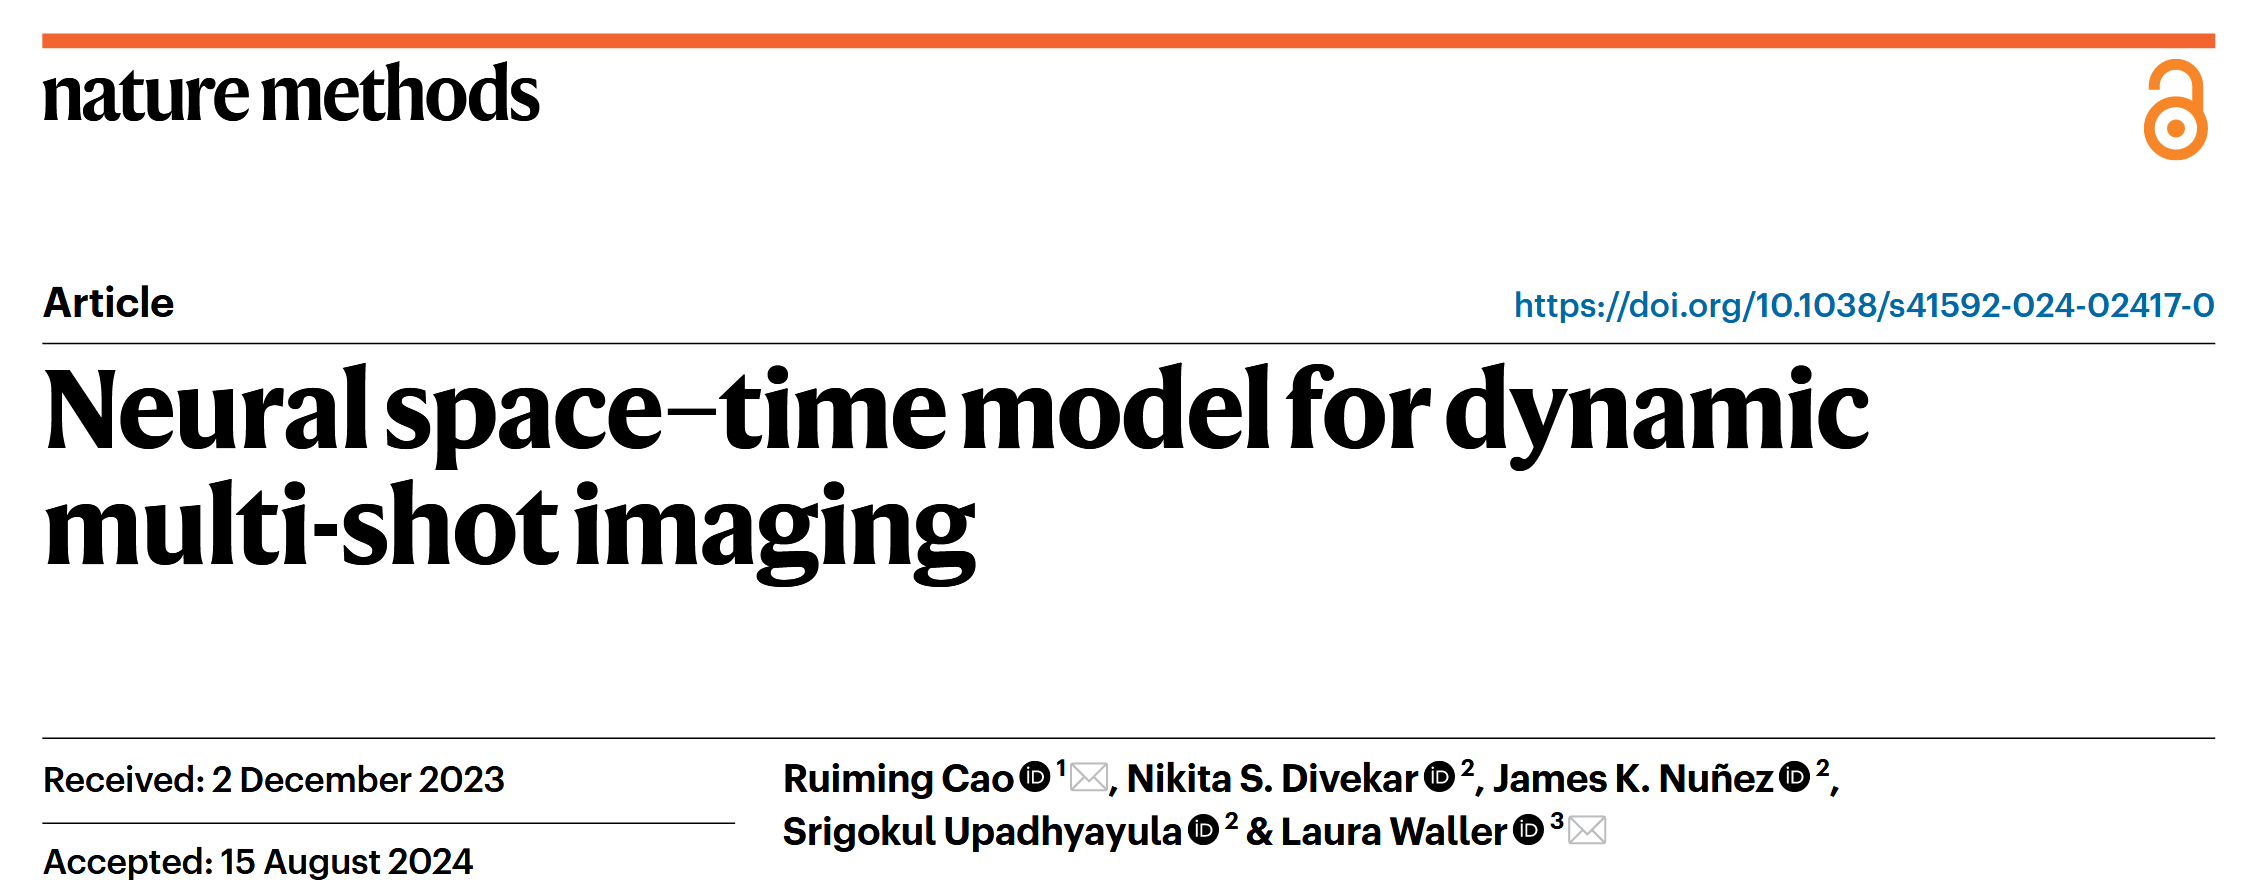
Github Repo: https://github.com/rmcao/nstm, 
Corresponding code: ../../../../code/NeRF_optics/nstm-main/examples/notebook-DPC.ipynb

## 1. Highlights

NSTM is the **first self-supervised framework** to jointly learn per-pixel motion and scene content from raw multi-shot measurements. It supports **any multi-shot system** with a differentiable forward model, including DPC, 3D SIM, and DiffuserCam. Also it enables **motion-aware reconstruction** that resolves artifacts in dynamic scenes, improving biological interpretability.n.

## 2. Background

Structured Illumination Microscopy (SIM) is a super-resolution imaging technique that breaks the diffraction limit. Traditional SIM achieves resolution enhancement by combining multiple images taken under varying illumination patterns. However, this leads to **slow acquisition speed** and **motion artifacts** when the sample moves during imaging. These methods have significantly expanded our ability to resolve biological structures, achieving breakthroughs in **super-resolution** [1], **phase retrieval** [2], and **video reconstruction from single images** [3].

However, a major limitation remains: **motion artifacts**. When imaging dynamic (moving) scenes, the assumption that the sample remains static during multi-shot acquisition breaks down. This mismatch leads to blurring, ghosting, and misinterpretation of structures. Traditional solutions try to either:
- speed up hardware acquisition,
- use pre-trained deep networks with strong priors,
- or register images post hoc assuming simple motion.

These strategies are often system-specific and don't generalize well, especially when ground truth data is unavailable or motion is complex.

## 3.The Core Idea
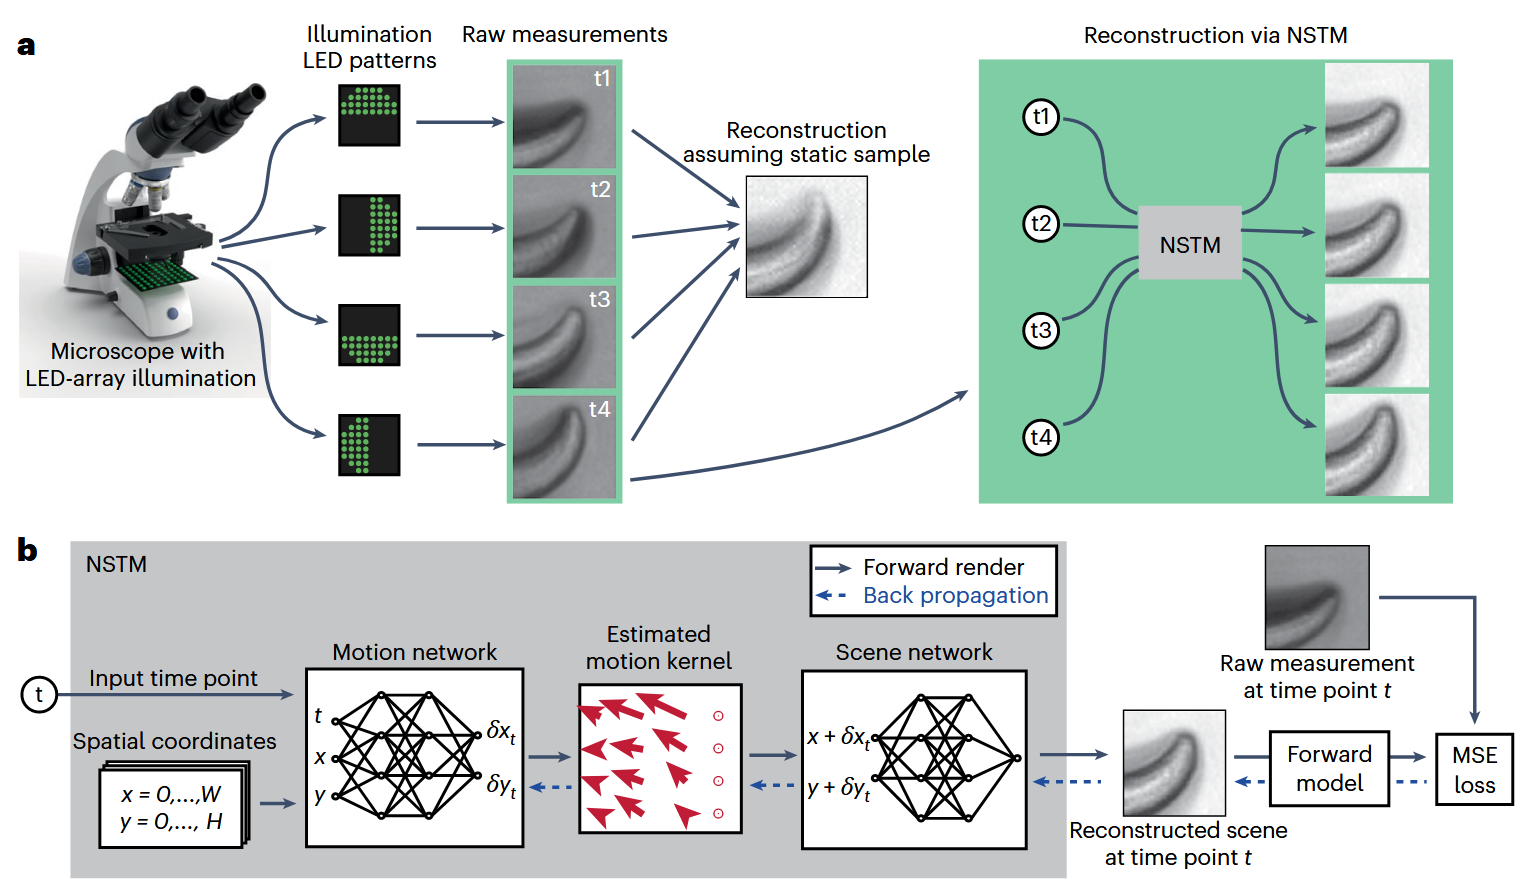
The central innovation of this paper is to **jointly predict motion and appearance** of a dynamic scene using two neural networks—trained entirely in a **self-supervised** manner from raw multi-shot measurements.

As illustrated in **Fig. 1a**, the system takes a sequence of raw images $I_{t_1}, I_{t_2}, I_{t_3}, I_{t_4}$ captured under different illumination conditions using an LED-array microscope. Each image corresponds to a slightly different time point, and due to sample motion, they do not align perfectly. A conventional reconstruction (middle) assumes a static scene and thus suffers from motion artifacts. In contrast, NSTM (right) reconstructs a clean scene at each time by modeling and correcting the motion.



### 3.1 Inputs and Outputs

As shown in **Fig. 1b**, the **inputs** to the model are:
- A spatial grid of coordinates $(x, y)$ covering the image domain,
- A temporal coordinate $t$ representing the time point of interest.

The **outputs** are:
- A reconstructed scene $o(x, y, t)$ at that time point,
- And ultimately, a synthetic measurement $\hat{I}_t$ generated by passing $o(x, y, t)$ through the system's forward model.



### 3.2 Network Structure (Fig. 1b)

The model consists of two coordinate-based neural networks (a form of **Implicit Neural Representation**, or INR):

1. **Motion Network**  
   Takes as input $(x, y, t)$ and outputs the motion displacement vector $(\delta x_t, \delta y_t)$:
   $$
   (\delta x_t, \delta y_t) = f_{\text{motion}}(x, y, t)
   $$
   This gives a **pixel-wise motion kernel** at time $t$.

2. **Scene Network**  
   Takes the **motion-compensated coordinate** $(x + \delta x_t, y + \delta y_t)$ and outputs the reconstructed scene value at that location:
   $$
   o(x, y, t) = f_{\text{scene}}(x + \delta x_t, y + \delta y_t)
   $$
   Note: The scene network does **not** depend on $t$ directly—it learns a static canonical scene which is warped over time by the motion field.



### 3.3 Forward Model and Self-Supervised Loss

Once the reconstructed scene $o(x, y, t)$ is obtained, it is passed through a **forward model** that simulates the image formation process of the actual imaging system:
$$
\hat{I}_t = F(o(x, y, t))
$$

The forward model $F$ is differentiable and specific to the imaging setup (e.g., DPC, SIM, DiffuserCam). It models how the scene would appear under the same conditions as the real measurement $I_t$.

The model is trained by minimizing the mean squared error (MSE) between the synthetic and real measurements:
$$
\mathcal{L} = \sum_t \|F(o(x, y, t)) - I_t\|^2
$$

This loss is backpropagated through both the forward model and the two networks. In this way, **the motion and the scene are jointly learned from scratch**, using only the raw measurements as supervision.



## References

[1] Huang, B., Bates, M. & Zhuang, X. (2009). Super-resolution fluorescence microscopy. *Annu. Rev. Biochem.*

[2] Park, Y., Depeursinge, C. & Popescu, G. (2018). Quantitative phase imaging in biomedicine. *Nat. Photonics*

[3] Antipa, N. et al. (2019). Video from stills: lensless imaging with rolling shutter. *IEEE Int. Conf. Comput. Photography*

# Neural space-time model example on differential phase contrast microscopy (DPC) data
Jupyter lab demo for "Neural space-time model for dynamic multi-shot imaging" by Ruiming Cao, et al. (2024)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/NeRF_optics/nstm-main"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import calcil as cc
import sys
sys.path.append("../../../../code/NeRF_optics/nstm-main")  # 把上一级目录（即项目根目录）加进 PYTHONPATH

from nstm import dpc_utils
from nstm import dpc_flow
from nstm import spacetime
from nstm import utils
from nstm.hash_encoding import HashParameters

## Load data

In [ ]:
data_path = '../../../code/NeRF_optics/nstm-main/examples/dpc_data.npz'
print(os.path.abspath(data_path))
with np.load(data_path) as d:
    img = d['img']
    s = d['s']
num_frames = 4
wavelength = 0.525
na = 0.25
pixel_size = 0.454

dim_yx = (320, 1000)
extent = [0, pixel_size * dim_yx[1], pixel_size * dim_yx[0], 0]

param = utils.SystemParameters(dim_yx, wavelength, na, pixel_size, RI_medium=1.0, padding_yx=(0,0))

## Visualize images

In [ ]:
f, ax = plt.subplots(1,1,figsize=(10, 4))
frame = []

def init():
    frame.append(ax.imshow(img[0], clim=(-1., 1.), cmap='gray'))
    ax.axis('off')
    f.tight_layout()

init()
def updateFrame(i):
    frame[0].set_data(img[i])

interact(updateFrame, i=IntSlider(min=0, max=3, step=1, value=0),)

## DPC transfer function

Visualizes the transfer functions used in Differential Phase Contrast (DPC) imaging

- `pupil`: Generates the pupil function, defining the system's frequency support based on NA and wavelength.
- `Hu`, `Hp`: Compute the absorption (`Hu`) and phase (`Hp`) transfer functions for each illumination source.
- The loop displays:
  - Top row: real part of `Hu` (absorption transfer),
  - Bottom row: imaginary part of `Hp` (phase transfer),
  using `fftshift` to center the frequency components.

Each column corresponds to a different illumination direction.

These transfer functions are the core components of the DPC forward model. During reconstruction, the predicted scene (absorption and phase) is passed through the forward model using `Hu` and `Hp` to generate simulated measurements, which are then compared with actual measurements to compute the loss. Therefore, this step directly determines how the model “sees” and evaluates the scene during training.

In [ ]:
pupil = cc.physics.wave_optics.genPupil(param.dim_yx, param.pixel_size, NA=param.na, wavelength=param.wavelength)
Hu, Hp = dpc_utils.gen_transfer_func(list_source=s, pupil=pupil, wavelength=param.wavelength, shifted_out=False)

f, axes = plt.subplots(2, s.shape[0], figsize=(12, 6))
for i in range(s.shape[0]):
    axes[0, i].imshow(np.fft.fftshift(Hu[i].real), extent=(0,1,0,1))
    axes[1, i].imshow(np.fft.fftshift(Hp[i].imag), extent=(0,1,0,1))

## Baseline reconstruction
⚠️ Warning: The code is still throwing an error.

```python
Cell In[14], line 5
      3 img=img[:,:,:320]
      4 Hu=Hu[:,:,:320]
----> 5 abs_baseline, phase_baseline = dpc_utils.dpc_tikhonov_solver(img, Hu, Hp, 1e-4, 1e-4, param.wavelength)

File ~/2025/MIT/code/NeRF_optics/nstm-main/nstm/dpc_utils.py:137, in dpc_tikhonov_solver(imgs, Hu, Hp, amp_reg, phase_reg, wavelength)
    136 def dpc_tikhonov_solver(imgs, Hu, Hp, amp_reg=5e-5, phase_reg=5e-5, wavelength=0.515):
--> 137     Hu=Hu.reshape(1, imgs.shape[1], 1, imgs.shape[-2],imgs.shape[-1]) #TODO
    138     Hp=Hp.reshape(1, imgs.shape[1], 1, imgs.shape[-2],imgs.shape[-1]) 
    139     AHA = [(Hu.conj() * Hu).sum(axis=0) + amp_reg, (Hu.conj() * Hp).sum(axis=0),
    140            (Hp.conj() * Hu).sum(axis=0), (Hp.conj() * Hp).sum(axis=0) + phase_reg]

ValueError: cannot reshape array of size 409600 into shape (1,320,1,320,320)

In [ ]:
abs_baseline, phase_baseline = dpc_utils.dpc_tikhonov_solver(img, Hu, Hp, 1e-4, 1e-4, param.wavelength)

## Reconstruction via neural space-time model

### Define NSTM parameters

In [ ]:
# model parameters
object_fine_hash_ratio = 0.4
object_base_hash_ratio = 0.05
motion_hash_ratio = 0.03
motion_hash_temporal = 2

hash_param = HashParameters(bounding_box=(np.array([-param.dim_yx[0] * 0.5, -param.dim_yx[1] * 0.5]),
                                          np.array([param.dim_yx[0] * 1.5, param.dim_yx[1] * 1.5])),
                            n_levels=8, n_features_per_level=2, log2_hashmap_size=16,
                            base_resolution=np.array([dim_yx[0]*object_base_hash_ratio*2, dim_yx[1]*object_base_hash_ratio*2]),
                            finest_resolution=np.array([dim_yx[0]*object_fine_hash_ratio*2, dim_yx[1]*object_fine_hash_ratio*2]))
hash_param_motion_spacetime = HashParameters(
    bounding_box=(np.array([0, 0, -1]), np.array([param.dim_yx[0], param.dim_yx[1], 1])),
    n_levels=8, n_features_per_level=2, log2_hashmap_size=16, base_resolution=np.array([1,1,1]),
    finest_resolution=np.round(np.array([dim_yx[0]*object_fine_hash_ratio*motion_hash_ratio, dim_yx[1]*object_fine_hash_ratio*motion_hash_ratio, motion_hash_temporal])))

object_mlp_param = spacetime.MLPParameters(net_depth=2, net_width=128,
                                           net_activation=nn.gelu, skip_layer=4)
motion_mlp_param = spacetime.MLPParameters(net_depth=2, net_width=32,
                                           net_activation=nn.elu, skip_layer=6)

spacetime_param = spacetime.SpaceTimeParameters(motion_mlp_param=motion_mlp_param,
                                                 object_mlp_param=object_mlp_param,
                                                 motion_embedding='hash_combined',
                                                 motion_embedding_param=hash_param_motion_spacetime,
                                                 object_embedding='hash', object_embedding_param=hash_param,
                                                 out_activation=lambda x: x)

### Data loader

In [ ]:
batch_size = 4
pat_indices = np.eye(4)
time_norm = np.linspace(-1,1,4)
data_loader = cc.data_utils.loader_from_numpy({'img': img, 
                                               't': time_norm.reshape((-1)),
                                               'ind_pat': pat_indices}, prefix_dim=(batch_size,),
                                              seed=85472, )
sample_input_dict = next(data_loader)[0]
num_steps_per_epoch = len(next(data_loader))

### initialize model

In [ ]:
model = dpc_flow.DPCFlow(param, s, spacetime_param, annealed_epoch=4000)

rng = jax.random.PRNGKey(0)
variables = model.init(rng, input_dict=sample_input_dict)

### Define loss function

In [ ]:
l2 = cc.loss.Loss(dpc_flow.gen_loss_l2(margin=5), 'l2')
reg_absorp = cc.loss.Loss(dpc_flow.gen_l2_reg_absorp(freq_space=False), 'reg_l2_absorp', has_intermediates=True)
reg_phase = cc.loss.Loss(dpc_flow.gen_l2_reg_phase(freq_space=False), 'reg_l2_phase', has_intermediates=True)
total_loss = l2  + reg_absorp * 1e-4 + reg_phase*1e-4

### Run reconstruction

In [ ]:
save_path = './checkpoint/DPC_c_elegans/'

recon_param = cc.reconstruction.ReconIterParameters(save_dir=save_path, n_epoch=5000,
                                                    keep_checkpoints=1, 
                                                    checkpoint_every=5000,
                                                    output_every=100, log_every=100)

object_mlp_params = cc.reconstruction.ReconVarParameters(lr=1e-3, opt='adam', 
                                                  opt_kwargs={'b1': 0.9, 'b2': 0.99, 'eps': 1e-15},
                                                  schedule='exponential',
                                                  schedule_kwargs={'transition_steps': 5e3, 'decay_rate': 0.1, 'transition_begin': 0},
                                                  update_every=1)
motion_mlp_params = cc.reconstruction.ReconVarParameters(lr=1e-5, opt='adam',
                                                     opt_kwargs={'b1': 0.9, 'b2': 0.99, 'eps': 1e-15},
                                                     schedule='exponential',
                                                     schedule_kwargs={'transition_steps': 5e3, 'decay_rate': 0.1, 'transition_begin': 0},
                                                     update_every=1)

var_params = {'params': {'spacetime': {'motion_mlp': motion_mlp_params, 'object_mlp': object_mlp_params,
                                       'motion_embedding': motion_mlp_params, 'object_embedding': object_mlp_params},}}

recon_variables, recon = cc.reconstruction.reconstruct_multivars_sgd(model.apply, variables, var_params,
                                                                     data_loader, total_loss, recon_param,
                                                                     None, None)

recon_t = np.array([model.apply(recon_variables, np.array([t]), np.array([[0, 0]]),
                                method=lambda module, a, b: module.spacetime(a, b))[0] for i, t in enumerate(time_norm.reshape((-1)))])


### Visualize the reconstruction

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
frames = []
margin = 20

clim_ = (np.percentile(recon_t[..., 0], 0.1), np.percentile(recon_t[..., 0], 99))
clim_phase = (np.percentile(recon_t[..., 1], 70), np.percentile(recon_t[..., 1], 99.99))

def init():
    frames.append(axes[0, 0].imshow(recon_t[0,margin:-margin,margin:-margin,0], cmap='gray', clim=clim_, interpolation='None'))
    frames.append(axes[1, 0].imshow(recon_t[0,margin:-margin,margin:-margin,1], cmap='gray', clim=clim_phase, interpolation='None'))
    frames.append(axes[0, 1].imshow(abs_baseline[margin:-margin, margin:-margin], cmap='gray',clim=clim_, interpolation='None'))
    frames.append(axes[1, 1].imshow(phase_baseline[margin:-margin, margin:-margin], cmap='gray', clim=clim_phase, interpolation='None'))
    
    axes[0,0].set_title('neural space-time model', fontsize=14)
    axes[0,1].set_title('conventional reconstruction', fontsize=14)
    axes[0,0].text(-0., 0.5, 'amplitude',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[0,0].transAxes, fontsize=14)
    axes[1,0].text(-0., 0.5, 'phase',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[1,0].transAxes, fontsize=14)

    axes[0,0].set_xlim([65, 765])
    [[ax.axis('off') for ax in axe] for axe in axes]
    f.tight_layout()
    
init()
def updateFrame(t):
    frames[0].set_data(recon_t[t,margin:-margin,margin:-margin,0])
    frames[1].set_data(recon_t[t,margin:-margin,margin:-margin,1])

interact(updateFrame, t=IntSlider(min=0, max=3, step=1, value=0))

## Temporal interpolation

In [ ]:
recon_t_dense = np.array([model.apply(recon_variables, np.array([t]), np.array([[0, 0]]),
                                method=lambda module, a, b: module.spacetime(a, b))[0] for t in np.linspace(-1,1,100)])

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
frames, text = [], []
margin = 20

frame_number_interp = np.linspace(1, 4, 100)

clim_ = (np.percentile(recon_t[..., 0], 0.1), np.percentile(recon_t[..., 0], 99))
clim_phase = (np.percentile(recon_t[..., 1], 70), np.percentile(recon_t[..., 1], 99.99))

def init():
    frames.append(axes[0, 0].imshow(recon_t[0,margin:-margin,margin:-margin,0], cmap='gray', clim=clim_, interpolation='None'))
    frames.append(axes[1, 0].imshow(recon_t[0,margin:-margin,margin:-margin,1], cmap='gray', clim=clim_phase, interpolation='None'))
    frames.append(axes[0, 1].imshow(abs_baseline[margin:-margin, margin:-margin], cmap='gray',clim=clim_, interpolation='None'))
    frames.append(axes[1, 1].imshow(phase_baseline[margin:-margin, margin:-margin], cmap='gray', clim=clim_phase, interpolation='None'))
    
    axes[0,0].set_title('neural space-time model', fontsize=14)
    axes[0,1].set_title('conventional reconstruction', fontsize=14)
    axes[0,0].text(-0., 0.5, 'amplitude',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[0,0].transAxes, fontsize=14)
    axes[1,0].text(-0., 0.5, 'phase',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[1,0].transAxes, fontsize=14)

    f.tight_layout()
    
    axes[0,0].set_xlim([65, 765])

    # text
    text.append(axes[0,0].text(105.5, 55.6, f'frame {0}', color='black', fontsize=14, ))

    # color bar
    f.colorbar(frames[0], ax=axes[0], location='right', anchor=(-0.3, 0.5), shrink=0.5)
    cbar_phase = f.colorbar(frames[1], ax=axes[1], location='right', anchor=(-0.3, 0.5), shrink=0.5, ticks=[0, 1, 2, 3, 4])
    
    [[ax.axis('off') for ax in axe] for axe in axes]

init()
def updateFrameVideo(i):
    text[0].set_text('frame {:0.2f}'.format(frame_number_interp[i]))
    frames[0].set_data(recon_t_dense[i,margin:-margin,margin:-margin,0])
    frames[1].set_data(recon_t_dense[i,margin:-margin,margin:-margin,1])

    frames[2].set_data(abs_baseline[margin:-margin, margin:-margin])
    frames[3].set_data(phase_baseline[margin:-margin, margin:-margin])

interact(updateFrameVideo, i=IntSlider(min=0, max=99, step=1, value=0))

## Reference